In [1]:
import json, os
import time
from timeit import default_timer as timer
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

import copy
import itertools

import seaborn as sns 
from matplotlib import pyplot as plt
import missingno as msno


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils.data import Dataset


from fastprogress import master_bar, progress_bar


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [2]:
plt.rcParams["figure.figsize"] = (13,8)
torch.manual_seed(0)

In [3]:
# data is not scaled
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("values.csv", index_col=False)
df.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
cpu = df.cpu.copy()

In [5]:
cpu

0        2.970
1        2.730
2        2.490
3        2.990
4        3.490
         ...  
6897    14.940
6898    15.720
6899    16.500
6900    16.215
6901    15.930
Name: cpu, Length: 6902, dtype: float64

In [6]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []
    
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [7]:
train_periods = 151
test_periods = 604

prediction_periods = test_periods

scaler = MinMaxScaler(feature_range=(-1, 1))
cpu_norm = scaler.fit_transform(cpu.to_numpy().reshape(-1, 1))


x, y = sliding_windows(cpu_norm, train_periods)
print(x.shape)
print(y.shape)

(6750, 151, 1)
(6750, 1)


In [8]:
x_data = torch.Tensor(np.array(x))
y_data = torch.Tensor(np.array(y))

x_train = torch.Tensor(np.array(x[:-train_periods]))
y_train = torch.Tensor(np.array(y[:-train_periods]))

x_test = torch.Tensor(np.array(x[-test_periods:]))
y_test = torch.Tensor(np.array(y[-test_periods:]))

In [9]:
print("train shape is:",x_train.size())
print("train label shape is:",y_train.size())
print("test shape is:",x_test.size())
print("test label shape is:",y_test.size())

train shape is: torch.Size([6599, 151, 1])
train label shape is: torch.Size([6599, 1])
test shape is: torch.Size([604, 151, 1])
test label shape is: torch.Size([604, 1])


In [10]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.1)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        #self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [11]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
epochs = 600
learning_rate = 1e-3
input_size = 1
hidden_size = 50
num_layers = 1

num_classes = 1


model = LSTM(num_classes, input_size, hidden_size, num_layers)

model.apply(init_weights)

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
optimizer = torch.optim.Adadelta(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [13]:


losses = []
for epoch in progress_bar(range(epochs)):
    start = timer()
    model.train()
    y_hat = model(x_train)
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    loss = criterion(y_hat, y_train)
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    
    model.eval()
    valid = model(x_test.to(device))
    vall_loss = criterion(valid, y_test)
    scheduler.step(vall_loss)
    end=timer()
    
    print(f'epoch: {epoch:4} loss:{loss.item(): 10.8f} validation loss: {vall_loss.item()} time: {timedelta(seconds=end-start)} ')
    

    

epoch:    0 loss: 0.41911063 validation loss: 0.3612293004989624 time: 0:00:09.848613 
epoch:    1 loss: 0.39424103 validation loss: 0.3374044597148895 time: 0:00:09.297991 
epoch:    2 loss: 0.36988276 validation loss: 0.3132040500640869 time: 0:00:09.183629 
epoch:    3 loss: 0.34511459 validation loss: 0.28761792182922363 time: 0:00:08.933575 
epoch:    4 loss: 0.31890035 validation loss: 0.25967201590538025 time: 0:00:09.232139 
epoch:    5 loss: 0.29023412 validation loss: 0.22847133874893188 time: 0:00:08.805693 
epoch:    6 loss: 0.25818387 validation loss: 0.19331340491771698 time: 0:00:08.036165 
epoch:    7 loss: 0.22200498 validation loss: 0.15399833023548126 time: 0:00:07.128987 
epoch:    8 loss: 0.18145324 validation loss: 0.11152105778455734 time: 0:00:04.766317 
epoch:    9 loss: 0.13748732 validation loss: 0.06930232793092728 time: 0:00:03.965894 
epoch:   10 loss: 0.09352964 validation loss: 0.03435155376791954 time: 0:00:03.935169 
epoch:   11 loss: 0.05669405 valida

In [14]:
model.eval()
with torch.no_grad():
    train_predict = model(x_data)
    data_predict = train_predict.data.numpy()

y_data_plot = y_data.data.numpy()

In [15]:
data_predict = scaler.inverse_transform(data_predict)
y_data_plot = scaler.inverse_transform(y_data_plot)

In [16]:
x = [y.to_pydatetime() for y in pd.date_range('2022-04-14 08:29:33',periods=6750, freq='s')]#.strftime(date_format='%d-%m-%Y %H:%M:%S').tolist()

df_predict = pd.DataFrame(data_predict,columns=['pred'], index=x)
df_predict['y'] = y_data_plot

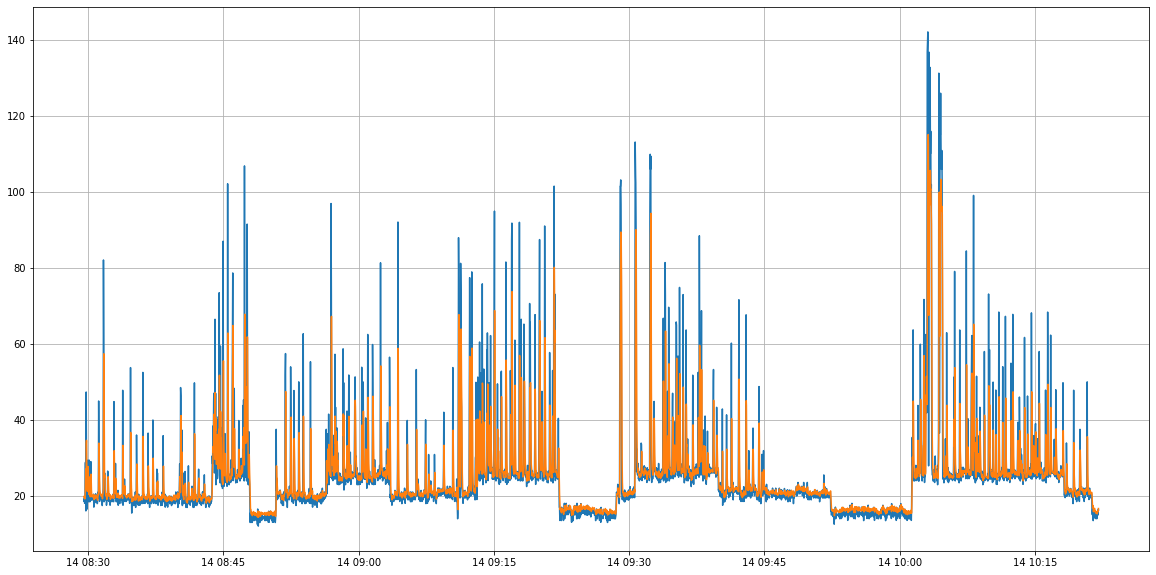

In [17]:

fig = plt.figure(figsize=(20,10))

plt.grid(True)
plt.plot( df_predict.y)
plt.plot(df_predict['pred'])


In [18]:
x_test.size()

torch.Size([604, 151, 1])

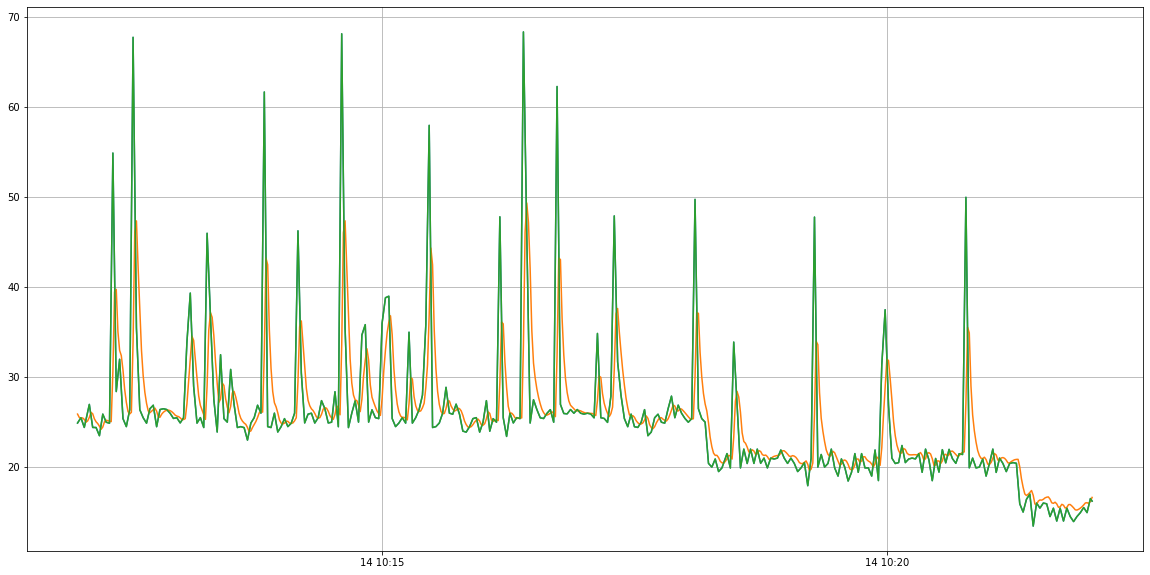

In [19]:
fig = plt.figure(figsize=(20,10))

plt.grid(True)
plt.plot(df_predict.y.iloc[-x_test.size()[0]:])
plt.plot(df_predict.iloc[-x_test.size()[0]:])

In [20]:

MODEL_PATH = f'/tmp/lstm_model_{datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}.pth'
torch.save(model.state_dict(), MODEL_PATH)